In [ ]:
# dependencies
# NumPy versions below 1.17 may be incompatible with some other 
# packages, so you may need to replace your current version with 
# an earlier one in order to run this notebook as-is. 
# !pip uninstall numpy --yes
# !pip install "numpy<1.17"
#pip install ipython
#pip install matplotlib
#pip install opencv-python
#pip install argparse


from IPython.display import Image
from matplotlib import pyplot as plt

import cv2
import argparse
import sys
import numpy as np
import pandas as pd
import os.path
import tensorflow as tf
from keras import backend as K
from keras import  optimizers,layers
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout,Activation
from keras.models import Model, Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# New Section

In [ ]:
#Enter path for the image to be tested
input_path = r'/content/drive/MyDrive/yolo_utils/1.jpg'

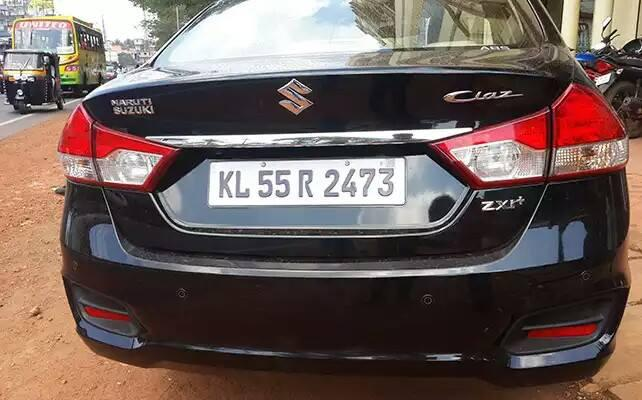

In [ ]:
Image(input_path)

In [ ]:
#Open the image file
cap = cv2.VideoCapture(input_path)

In [ ]:
# Initialize the parameters

confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #Width of network's input image
inpHeight = 416     #Height of network's input image

In [ ]:
# Load names of classes
classesFile = "/content/drive/MyDrive/yolo_utils/classes.names";

In [ ]:
# Append all different classes into the list 'classes'
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [ ]:
classes

['LP']

In [ ]:
#!unzip /content/drive/MyDrive/yolo_utils.zip -d /content/drive/MyDrive

In [ ]:
modelConfiguration = r"/content/drive/MyDrive/yolo_utils/darknet-yolov3.cfg";
modelWeights = r"/content/drive/MyDrive/yolo_utils/lapi.weights";

In [ ]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [ ]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom, frame):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [ ]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        #print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        # drawPred
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

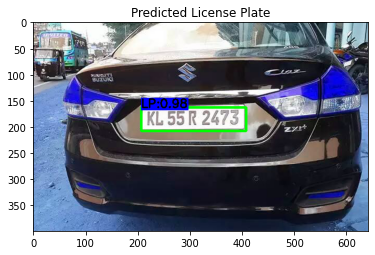

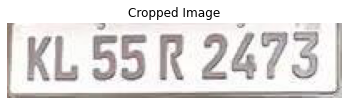

Done processing !!!


In [ ]:
while cv2.waitKey(1) < 0:

    hasFrame, frame = cap.read() #frame: an image object from cv2

    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        break

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    cropped = postprocess(frame, outs)

    plt.imshow(frame)
    plt.title("Predicted License Plate")
    plt.show()
    plt.imshow(cropped)
    plt.title("Cropped Image")
    plt.axis('off')
    plt.show()
    

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

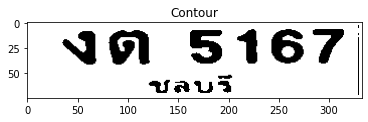

43 12.5 37.5 | 36 33.3 222.0
34 12.5 37.5 | 36 33.3 222.0
34 12.5 37.5 | 35 33.3 222.0
36 12.5 37.5 | 35 33.3 222.0
33 12.5 37.5 | 36 33.3 222.0
22 12.5 37.5 | 36 33.3 222.0


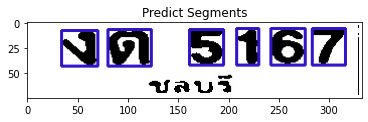

In [ ]:
# Find characters in the resulting images
def segment_thaicharacters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)
    # newImage = img_binary_lp.copy()
    # cv2.drawContours(newImage, dimensions, -1, (0,255,255), -1)
    # cv2.rectangle(newImage,(12,37),(222,33),(0,255,0),3)
    # cntrs, _ = cv2.findContours(img_binary_lp.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(newImage, cntrs, -1, (0,255,255), -1)
    # plt.imshow(newImage, cmap='gray')
    # plt.title('Contour')
    # plt.show()

    # print(dimensions)
    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        # print(cntr)
        # checking the dimensions of the contour to filter out the characters by contour's size
        # if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
        if  intWidth > lower_width and intHeight > 20  and intWidth <img.shape[0] and intHeight <img.shape[1]:
            print(intWidth,lower_width,upper_width,"|",intHeight,lower_height,upper_height)
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res
cropped2 = cv2.imread('/content/3.jpg')

char=segment_thaicharacters(cropped2)

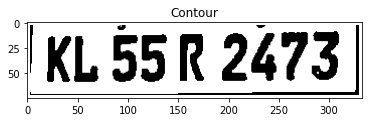

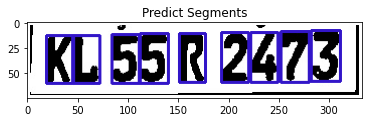

In [ ]:
char=segment_characters(cropped)

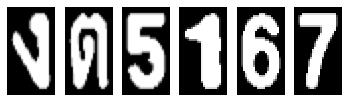

In [ ]:
for i in range(len(char)):
    # print(char[i])
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


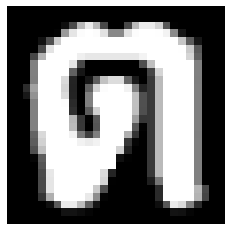

In [ ]:
print(char[0])
img = cv2.resize(char[1], (28,28), interpolation=cv2.INTER_AREA)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
# !unzip /content/drive/MyDrive/yolo_utils/dataset.zip -d /content/drive/MyDrive/yolo_utils

# New Section

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255, width_shift_range=0.1, height_shift_range=0.1,validation_split=0.2 )
path = '/content/drive/MyDrive/yolo_utils/dataset'
names=['class_0','class_1','class_2','class_3','class_4','class_5','class_6','class_7','class_8','class_9',
       'class_10','class_11','class_12','class_13','class_14','class_15','class_16','class_17','class_18','class_19',
       'class_20','class_21','class_22','class_23','class_24','class_25','class_26','class_27','class_28','class_29',
       'class_30','class_31','class_32','class_33','class_34','class_35','class_36','class_37','class_38','class_39',
       'class_40','class_41','class_42','class_43','class_44','class_45','class_46','class_47','class_48','class_49',
       'class_50','class_51','class_52','class_53']
train_generator = train_datagen.flow_from_directory(
        path,  # this is the target directory
        classes=names,
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
            seed=107, 
            # batch_size=128,
    subset='training',
        color_mode='grayscale',
        shuffle=True,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        path,  # this is the target directory
        classes=names,
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        color_mode='grayscale',
    seed=107,
    # batch_size=128,
    subset='validation',
    shuffle=True,
        class_mode='categorical')

Found 21600 images belonging to 54 classes.
Found 5400 images belonging to 54 classes.


ปฎ1ตภ


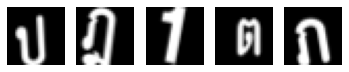

In [ ]:
x, y = train_generator.next()

characters = '0123456789กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮ'
_char = ''
for i in range(5):
    _char += characters[np.argmax(y[i])]
    plt.subplot(1, 5, i+1)
    plt.imshow(x[i][:,:,0], cmap='gray')
    plt.axis('off')

print(_char)
plt.show()

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5426770797069176305
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4682965609647085492
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(54))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [ ]:
from keras.models import load_model,model_from_json
json_file = open('/content/drive/MyDrive/yolo_utils/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/content/drive/MyDrive/yolo_utils/model.h5")
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [ ]:

score = model.evaluate(validation_generator,verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

169/169 [==============================] - 8s 49ms/step - loss: 3.7478 - accuracy: 0.1639
accuracy: 16.39%


In [ ]:
# model.fit(
#         train_generator,
#         samples_per_epoch=21600,
#         nb_epoch=10,
#         validation_data=validation_generator,)
batch_size = 128
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 1, verbose=1, callbacks=None )

 65/168 [==========>...................] - ETA: 3:34 - loss: 3.7760 - accuracy: 0.0909

KeyboardInterrupt: ignored

In [ ]:
with open('/content/drive/MyDrive/yolo_utils/model.json', 'w') as f:
    f.write(model.to_json())
model.save_weights('/content/drive/MyDrive/yolo_utils/model.h5', overwrite=True)

In [ ]:
model.evaluate(validation_generator,verbose=1)

43/43 [==============================] - 13s 297ms/step - loss: 3.7520 - accuracy: 0.1598


[3.751986503601074, 0.15981481969356537]

In [ ]:
K.clear_session()
model = Sequential()
# model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(4, 4)))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(54, activation='softmax'))
# ***********************
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(54, activation='softmax'))
# *****
# model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(4, 4)))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(54, activation='softmax'))

# model.add(Conv2D(64,(3,3), input_shape=(28, 28, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64,(3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dense(54))
# model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

In [ ]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:

print(x_train.shape[1:])

(32, 32, 3)


In [ ]:
K.clear_session()
model = Sequential()

model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(28, 28, 3)))

model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))

model.add(layers.Conv2D(256, 5, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))

model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(54, activation='softmax'))
# model.summary()

#AlexNet
# model = Sequential()
# model.add(layers.experimental.preprocessing.Resizing(256, 256, interpolation="bilinear", input_shape=(28, 28, 1)))
# # 1st Convolutional Layer
# model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'))
# # Max Pooling
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# # 2nd Convolutional Layer
# model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation='relu'))
# # Max Pooling
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# # 3rd Convolutional Layer
# model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))

# # 4th Convolutional Layer
# model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))

# # 5th Convolutional Layer
# model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
# # Max Pooling
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# # Passing it to a Fully Connected layer
# model.add(Flatten())
# # 1st Fully Connected Layer
# model.add(Dense(128, input_shape=(256*256*1,), activation='relu'))
# # Add Dropout to prevent overfitting
# model.add(Dropout(0.4))

# # 2nd Fully Connected Layer
# #model.add(Dense(128, activation='relu'))
# # Add Dropout
# #model.add(Dropout(0.4))

# # 3rd Fully Connected Layer
# model.add(Dense(54, activation='softmax'))
# # Add Dropout
# #model.add(Dropout(0.4))

# # Output Layer
# #model.add(Dense(55, activation='softmax'))
# model.summary()

# input = tf.keras.Input(shape=(32,32,3))
# efnet = tf.keras.applications.ResNet50(weights='imagenet',
#                                              include_top = False, 
#                                              input_tensor = input)
# # Now that we apply global max pooling.
# gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

# # Finally, we add a classification layer.
# output = tf.keras.layers.Dense(54, activation='softmax', use_bias=True)(gap)

# # bind all
# model = tf.keras.Model(efnet.input, output)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 56, 56, 96)        0         
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                        

In [ ]:
input = tf.keras.Input(shape=(32,32,3))
efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input)

# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(54, activation='softmax', use_bias=True)(gap)

# bind all
func_model = tf.keras.Model(efnet.input, output)
func_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_35[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

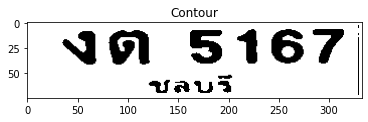

43 12.5 37.5 | 36 33.3 222.0
34 12.5 37.5 | 36 33.3 222.0
34 12.5 37.5 | 35 33.3 222.0
36 12.5 37.5 | 35 33.3 222.0
33 12.5 37.5 | 36 33.3 222.0
22 12.5 37.5 | 36 33.3 222.0


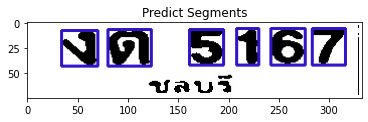

In [ ]:
cropped2 = cv2.imread('/content/3.jpg')

char=segment_thaicharacters(cropped2)

In [ ]:
model = Sequential()
model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(28, 28, 3)))
output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)
input = tf.keras.Input(shape=(32,32,3))
efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = model.input)
# func_model = tf.keras.Model(model.input, output)
efnet.input

<KerasTensor: shape=(None, 28, 28, 3) dtype=float32 (created by layer 'resizing_20_input')>

In [ ]:
K.clear_session()
input = tf.keras.Input(shape=(32,32,3))
efnet = tf.keras.applications.xception(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input)
# Building Customized CNN model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 3)),
    tf.keras.layers.experimental.preprocessing.Resizing(32, 32),
    efnet,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(54, activation = 'softmax'),
])

model.summary() 

NameError: ignored

In [ ]:
early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights=True)
cp_cb = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/yolo_utils/models/saved_model_giant_ml', monitor='val_accuracy', save_best_only=True)
# model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

In [ ]:
efnet.trainable=False
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics='accuracy')

batch_size = 4
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 50, verbose=1, callbacks=[early_cb, cp_cb] )

Epoch 1/50
1242/1242 [==============================] - 73s 55ms/step - loss: 3.7580 - accuracy: 0.0338 - val_loss: 3.5379 - val_accuracy: 0.0444
Epoch 2/50
1242/1242 [==============================] - 67s 54ms/step - loss: 3.4042 - accuracy: 0.0539 - val_loss: 3.3324 - val_accuracy: 0.0537
Epoch 3/50
1242/1242 [==============================] - 67s 54ms/step - loss: 3.2393 - accuracy: 0.0652 - val_loss: 3.1437 - val_accuracy: 0.0741
Epoch 4/50
1242/1242 [==============================] - 66s 53ms/step - loss: 3.1127 - accuracy: 0.0821 - val_loss: 3.0701 - val_accuracy: 0.0796
Epoch 5/50
1242/1242 [==============================] - 68s 55ms/step - loss: 2.9901 - accuracy: 0.1006 - val_loss: 3.0151 - val_accuracy: 0.0926
Epoch 6/50
1242/1242 [==============================] - 64s 52ms/step - loss: 2.9555 - accuracy: 0.0845 - val_loss: 2.8709 - val_accuracy: 0.1315
Epoch 7/50
1242/1242 [==============================] - 36s 29ms/step - loss: 2.8642 - accuracy: 0.1159 - val_loss: 2.7711 -

In [ ]:

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
GPU is NOT AVAILABLE


In [ ]:
callbacks_list = [
tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy', min_delta=0.001, 
patience=10, verbose=1, mode='auto',
baseline=None, restore_best_weights=True),
tf.keras.callbacks.ReduceLROnPlateau(
monitor='val_accuracy',
factor=0.5,
patience=5,
verbose=1,
mode='auto'),
tf.keras.callbacks.ModelCheckpoint(
filepath='./my_model.h5',
monitor='val_accuracy',
save_best_only=True,
)
]

In [ ]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
batch_size = 512
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 5, verbose=1, callbacks=callbacks_list )
model.save('/content/drive/MyDrive/yolo_utils/models/thaicha-28-2.h5')

GPU is NOT AVAILABLE
Epoch 1/5
9/9 [==============================] - 100s 12s/step - loss: 3.9890 - accuracy: 0.0000e+00 - val_loss: 5.3333 - val_accuracy: 0.0167 - lr: 1.0000e-04
Epoch 2/5
9/9 [==============================] - 6s 747ms/step - loss: 3.9892 - accuracy: 0.0000e+00 - val_loss: 6.7352 - val_accuracy: 0.0204 - lr: 1.0000e-04
Epoch 3/5
9/9 [==============================] - 10s 1s/step - loss: 3.9888 - accuracy: 0.0000e+00 - val_loss: 8.1550 - val_accuracy: 0.0241 - lr: 1.0000e-04
Epoch 4/5
9/9 [==============================] - ETA: 0s - loss: 3.9886 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

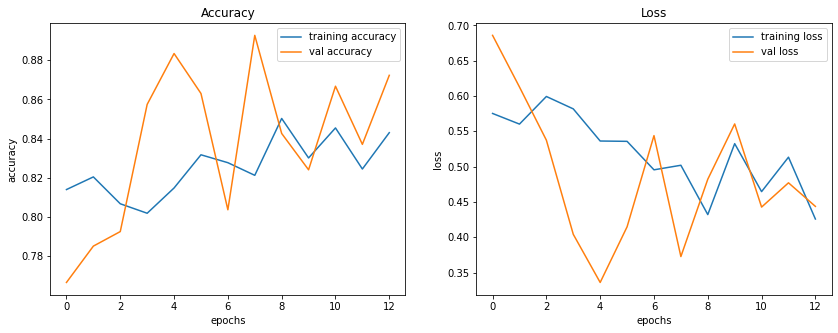

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
model.save_weights('/content/drive/MyDrive/yolo_utils/models/thaicha-k-0063-0998.h5')

In [ ]:
model.save('/content/drive/MyDrive/yolo_utils/models/thaicha-28.h5')

In [ ]:
model.evaluate(validation_generator,verbose=1)

17/17 [==============================] - 2s 102ms/step - loss: 0.8071 - accuracy: 0.8130


[0.8070887923240662, 0.8129629492759705]

In [ ]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(54, activation='softmax'))

# Restore the weights
loaded_model.load_weights('/content/drive/MyDrive/yolo_utils/models/checkpoints/thaicha-k')

In [ ]:
loaded_model =  load_model('/content/drive/MyDrive/yolo_utils/models/saved_model_giant_ml')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                        

In [ ]:
loaded_model.save()

In [ ]:
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics='accuracy')
batch_size = 1
result = loaded_model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 30, verbose=1, callbacks=None)

Epoch 1/30
2700/2700 [==============================] - 29s 11ms/step - loss: 0.0454 - accuracy: 0.9900 - val_loss: 0.0636 - val_accuracy: 0.9889
Epoch 2/30
2700/2700 [==============================] - 28s 10ms/step - loss: 0.0529 - accuracy: 0.9878 - val_loss: 0.0214 - val_accuracy: 0.9926
Epoch 3/30
2700/2700 [==============================] - 28s 10ms/step - loss: 0.0379 - accuracy: 0.9896 - val_loss: 5.4073e-04 - val_accuracy: 1.0000
Epoch 4/30
2700/2700 [==============================] - 28s 11ms/step - loss: 0.0285 - accuracy: 0.9948 - val_loss: 0.0159 - val_accuracy: 0.9926
Epoch 5/30
2700/2700 [==============================] - 29s 11ms/step - loss: 0.0540 - accuracy: 0.9870 - val_loss: 0.0090 - val_accuracy: 0.9963
Epoch 6/30
2700/2700 [==============================] - 29s 11ms/step - loss: 0.0374 - accuracy: 0.9896 - val_loss: 0.0410 - val_accuracy: 0.9889
Epoch 7/30
2700/2700 [==============================] - 28s 11ms/step - loss: 0.0493 - accuracy: 0.9915 - val_loss: 0.08

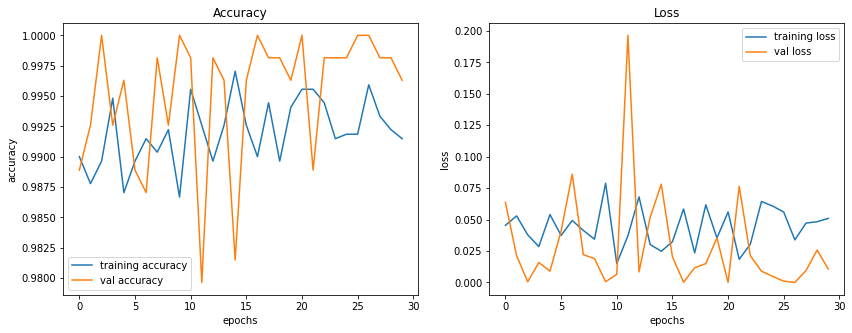

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
loaded_model.evaluate(train_generator,verbose=1)

ValueError: ignored

In [ ]:
loaded_model.save_weights('/content/drive/MyDrive/yolo_utils/models/checkpoints/thaicha')

In [ ]:
loaded_model.evaluate(validation_generator,verbose=1)

17/17 [==============================] - 145s 9s/step - loss: 2.1262 - accuracy: 0.2870


[2.1261849403381348, 0.28703704476356506]

ณ38ฐ8ฐ


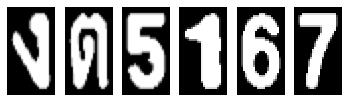

In [ ]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        # plt.imshow(img, cmap='gray')
        # plt.axis('off')
        # plt.show()

        # y_ = loaded_model.predict_classes(img)[0] #predicting the class
        predict =loaded_model.predict(img)
        y_=np.argmax(predict,axis=1)[0]
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())
for i in range(len(char)):
    # print(char[i])
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3603 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 3603 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 3600 missing from current font.
  font.set_text(s, 0, flags=flags)


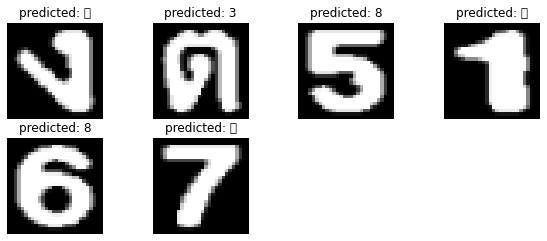

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [ ]:
!unzip /content/drive/MyDrive/yolo_utils/data.zip -d /content/drive/MyDrive/yolo_utils

Archive:  /content/drive/MyDrive/yolo_utils/data.zip
 extracting: /content/drive/MyDrive/yolo_utils/data/train/class_0/0_original_1.png_0110f542-0068-45ab-811b-04688808bb34.png  
 extracting: /content/drive/MyDrive/yolo_utils/data/train/class_0/0_original_1.png_08c0cfd8-faf9-466a-beb8-693a62f29b0e.png  
 extracting: /content/drive/MyDrive/yolo_utils/data/train/class_0/0_original_1.png_102ba0d8-9810-4353-985d-f4d0b19dd093.png  
 extracting: /content/drive/MyDrive/yolo_utils/data/train/class_0/0_original_1.png_149add06-13fa-4fb0-b0bc-4281301ab41c.png  
 extracting: /content/drive/MyDrive/yolo_utils/data/train/class_0/0_original_1.png_1e35a649-3805-4428-9116-38e202f1e871.png  
 extracting: /content/drive/MyDrive/yolo_utils/data/train/class_0/0_original_1.png_1e968c76-2492-43b5-9f74-43882e5b0fc1.png  
 extracting: /content/drive/MyDrive/yolo_utils/data/train/class_0/0_original_1.png_1e9faa60-3145-4c4c-b52e-2995fbe361a0.png  
 extracting: /content/drive/MyDrive/yolo_utils/data/train/class_0

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-1-g66aaf51 torch 1.10.0+cu111 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.1/107.7 GB disk)


In [ ]:
import torch

# Model
model = torch.hub.load('/content/yolov5', 'custom', path='/content/drive/MyDrive/models/thaicha-10k-l-10.pt', source='local') 

# Image
# img = '/content/yolov5/data/2.png'
img = cv2.resize(char[1], (64,64), interpolation=cv2.INTER_AREA)
# Inference
results = model(img)

results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (panda
#      xmin    ymin    xmax   ymax  confidence  class    name
# 0  749.50   43.50  1148.0  704.5    0.874023      0  person
# 1  433.50  433.50   517.5  714.5    0.687988     27     tie
# 2  114.75  195.75  1095.0  708.0    0.624512      0  person
# 3  986.00  304.00  1028.0  420.0    0.286865     27     tie

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-1-g66aaf51 torch 1.10.0+cu111 CPU

Fusing layers... 
Model Summary: 367 layers, 46393683 parameters, 0 gradients, 108.7 GFLOPs
Adding AutoShape... 
Saved 1 image to runs/detect/exp4


,xmin,ymin,xmax,ymax,confidence,class,name
0,52.258961,11.144738,54.607765,14.324086,0.309440,14,kon
1,52.306355,12.734286,54.602165,15.952505,0.273817,14,kon
2,59.485901,50.310673,61.552601,52.513409,0.273416,14,kon
3,59.527416,48.689827,61.537254,50.835125,0.256995,14,kon
4,52.288189,17.707588,54.606842,20.797222,0.251076,14,kon




```
# This is formatted as code
```

# Test wechat

In [ ]:
import requests
from tqdm import tqdm
import os

fileurl = 'http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz'
filename = 'EnglishFnt.tgz'
if not os.path.exists(filename):
    r = requests.get(fileurl, stream=True)
    with open(filename, 'wb') as f:
        for chunk in tqdm(r.iter_content(1024), unit='KB', total=int(r.headers['Content-Length'])/1024): 
            f.write(chunk)

48651KB [00:07, 6715.42KB/s]                                     


In [ ]:
import tarfile
import shutil

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def rmdir(path):
    if os.path.exists(path):
        shutil.rmtree(path)

with tarfile.open(filename, 'r') as tfile:
    print('loading')
    members = tfile.getmembers()
    for member in tqdm(members):
        if tarfile.TarInfo.isdir(member):
            mkdir(member.name)
            continue
        with open(member.name, 'wb') as f:
            f.write(tfile.extractfile(member).read())

loading


100%|██████████| 63055/63055 [00:06<00:00, 9173.93it/s]


In [ ]:
notnumdir = 'English/Fnt/Sample011/'
for i in tqdm(range(12, 63)):
    path = 'English/Fnt/Sample%03d/' % i
    for filename in os.listdir(path):
        os.rename(path+filename, notnumdir+filename)
    os.rmdir(path)

100%|██████████| 51/51 [00:01<00:00, 33.48it/s]


In [ ]:
import cv2
import numpy as np

def resize(rawimg):  # resize img to 28*28
    fx = 28.0 / rawimg.shape[0]
    fy = 28.0 / rawimg.shape[1]
    fx = fy = min(fx, fy)
    img = cv2.resize(rawimg, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
    outimg = np.ones((28, 28), dtype=np.uint8) * 255
    w = img.shape[1]
    h = img.shape[0]
    x = (28 - w) / 2
    y = (28 - h) / 2
    outimg[y:y+h, x:x+w] = img
    return outimg

def convert(imgpath):
    img = cv2.imread(imgpath)
    gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 25)[1]
    ctrs, hier = cv2.findContours(bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    for i,cnt in enumerate(ctrs):
      print(i)
    #   x, y, w, h = cv2.boundingRect(cnt)
    #   roi = gray[y:y+h, x:x+w]
    # roi = resize(roi)
    # return roi

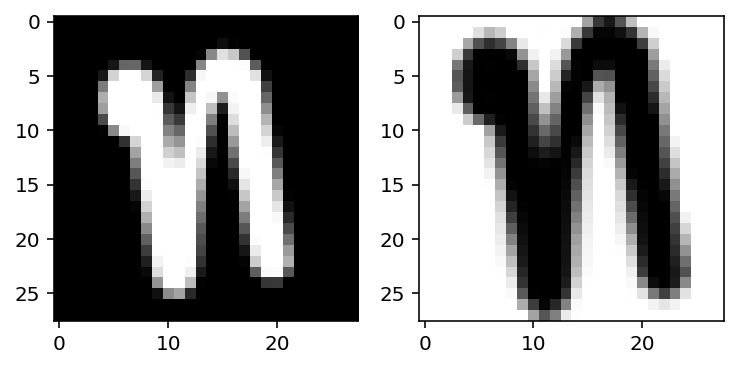

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def resize(rawimg):  # resize img to 28*28
    fx = 28.0 / rawimg.shape[0]
    fy = 28.0 / rawimg.shape[1]
    fx = fy = min(fx, fy)
    img = cv2.resize(rawimg, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
    # 
    outimg = np.ones((28, 28), dtype=np.uint8) * 255

    w = img.shape[1]
    h = img.shape[0]
    x = (28 - w) / 2
    y = (28 - h) / 2
    outimg[int(y):int(y+h), int(x):int(x+w)] = img
    return outimg

def convert(imgpath):
    img = cv2.imread(imgpath)
    img = cv2.bitwise_not(img)
    gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY) #cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 25)
    ctrs, hier = cv2.findContours(bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    x, y, w, h = rects[-1]
    roi = gray[y:y+h, x:x+w]
    return resize(roi)


   
    


%matplotlib inline

imgpath = '/content/drive/MyDrive/yolo_utils/dataset/class_32/haan_original_1.png_01d2c688-1d89-4820-8918-4c1512d20290.png'
img = cv2.imread(imgpath)
# img = cv2.bitwise_not(img)
rsz = convert(imgpath)
# rsz = cv2.bitwise_not(rsz)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(rsz, cmap='gray')

In [ ]:
rmdir('train')

for i in range(11):
    path = 'English/Fnt/Sample%03d/' % (i+1)
    trainpath = 'train/%d/' % i
    mkdir(trainpath)
    for filename in tqdm(os.listdir(path), desc=trainpath):
        try:
            cv2.imwrite(trainpath + filename, convert(path + filename))
        except:
            pass

train/10/: 100%|██████████| 52832/52832 [00:33<00:00, 1553.89it/s]


In [ ]:
from sklearn.model_selection import train_test_split
for i in range(11):
    trainpath = 'train/%d/' % i
    validpath = 'valid/%d/' % i
    mkdir(validpath)
    imgs = os.listdir(trainpath)
    trainimgs, validimgs = train_test_split(imgs, test_size=0.1)
    for filename in validimgs:
        os.rename(trainpath+filename, validpath+filename)

# Training Model Wechat

In [ ]:
!unzip /content/drive/MyDrive/wechat/dataset.zip -d /content/drive/MyDrive/wechat

Streaming output truncated to the last 5000 lines.
 extracting: /content/drive/MyDrive/wechat/dataset/class_13/khwaai_original_1.png_77264dd8-e3f3-4649-8bc0-3279556b1c32.png  
 extracting: /content/drive/MyDrive/wechat/dataset/class_13/khwaai_original_1.png_79d522b7-02bb-464f-a72c-336c062fd676.png  
 extracting: /content/drive/MyDrive/wechat/dataset/class_13/khwaai_original_1.png_7ab6f593-ca2f-4465-b1f7-2707cdcf9a72.png  
 extracting: /content/drive/MyDrive/wechat/dataset/class_13/khwaai_original_1.png_7ecbd120-9710-4fb9-b6c4-f6c91426d711.png  
 extracting: /content/drive/MyDrive/wechat/dataset/class_13/khwaai_original_1.png_84e57373-cc9e-4c03-a17f-3568cadb9684.png  
 extracting: /content/drive/MyDrive/wechat/dataset/class_13/khwaai_original_1.png_871ccf15-9469-48cd-8ab7-8431ea7f8d68.png  
 extracting: /content/drive/MyDrive/wechat/dataset/class_13/khwaai_original_1.png_8748c024-f779-434e-a891-c776da2d53f3.png  
 extracting: /content/drive/MyDrive/wechat/dataset/class_13/khwaai_origina

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255, width_shift_range=0.1, height_shift_range=0.1,validation_split=0.2 )
path = '/content/drive/MyDrive/wechat/dataset'
names=['class_0','class_1','class_2','class_3','class_4','class_5','class_6','class_7','class_8','class_9',
       'class_10','class_11','class_12','class_13','class_14','class_15','class_16','class_17','class_18','class_19',
       'class_20','class_21','class_22','class_23','class_24','class_25','class_26','class_27','class_28','class_29',
       'class_30','class_31','class_32','class_33','class_34','class_35','class_36','class_37','class_38','class_39',
       'class_40','class_41','class_42','class_43','class_44','class_45','class_46','class_47','class_48','class_49',
       'class_50','class_51','class_52','class_53']
train_generator = train_datagen.flow_from_directory(
        path,  # this is the target directory
        classes=names,
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
            seed=107, 
            # batch_size=128,
    subset='training',
        color_mode='grayscale',
        shuffle=True,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        path,  # this is the target directory
        classes=names,
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        color_mode='grayscale',
    seed=107,
    # batch_size=128,
    subset='validation',
    shuffle=True,
        class_mode='categorical')

Found 4320 images belonging to 54 classes.
Found 1080 images belonging to 54 classes.


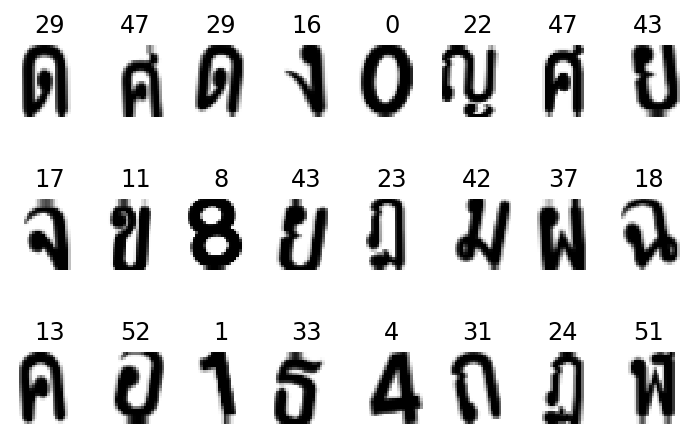

In [ ]:
x, y = train_generator.next()

for i in range(24):
  plt.subplot(3, 8, i+1)
  plt.title(str(np.argmax(y[i])))
  plt.axis('off')
  plt.imshow(x[i][:,:,0], interpolation="nearest", cmap='gray')


In [ ]:
from keras.models import load_model,model_from_json
json_file = open('/content/drive/MyDrive/wechat/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/content/drive/MyDrive/yolo_utils/models/saved_model_wechat_sk")
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
model.summary()
# from keras.models import load_model,model_from_json
# json_file = open('/content/model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# model.load_weights("/content/model (1).h5")
# model.compile(loss='categorical_crossentropy',
#               optimizer='adadelta',
#               metrics=['accuracy'])
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(11))
model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adadelta',
#               metrics=['accuracy'])

# model.summary()

In [ ]:
early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights=True)
cp_cb = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/yolo_utils/models/saved_model_wechat_sk', monitor='val_accuracy', save_best_only=True)

In [ ]:
batch_size = 32
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 100, verbose=1, callbacks=[cp_cb] )

Epoch 1/100
135/135 [==============================] - 13s 93ms/step - loss: 0.5486 - accuracy: 0.8405 - val_loss: 0.3729 - val_accuracy: 0.9315
Epoch 2/100
135/135 [==============================] - 13s 93ms/step - loss: 0.5487 - accuracy: 0.8375 - val_loss: 0.3578 - val_accuracy: 0.9417
Epoch 3/100
135/135 [==============================] - 12s 91ms/step - loss: 0.5425 - accuracy: 0.8426 - val_loss: 0.3605 - val_accuracy: 0.9361
Epoch 4/100
135/135 [==============================] - 12s 92ms/step - loss: 0.5493 - accuracy: 0.8424 - val_loss: 0.3563 - val_accuracy: 0.9407
Epoch 5/100
135/135 [==============================] - 12s 91ms/step - loss: 0.5405 - accuracy: 0.8431 - val_loss: 0.3546 - val_accuracy: 0.9315
Epoch 6/100
135/135 [==============================] - 12s 91ms/step - loss: 0.5508 - accuracy: 0.8417 - val_loss: 0.3628 - val_accuracy: 0.9361
Epoch 7/100
135/135 [==============================] - 12s 91ms/step - loss: 0.5242 - accuracy: 0.8465 - val_loss: 0.3537 - val_ac

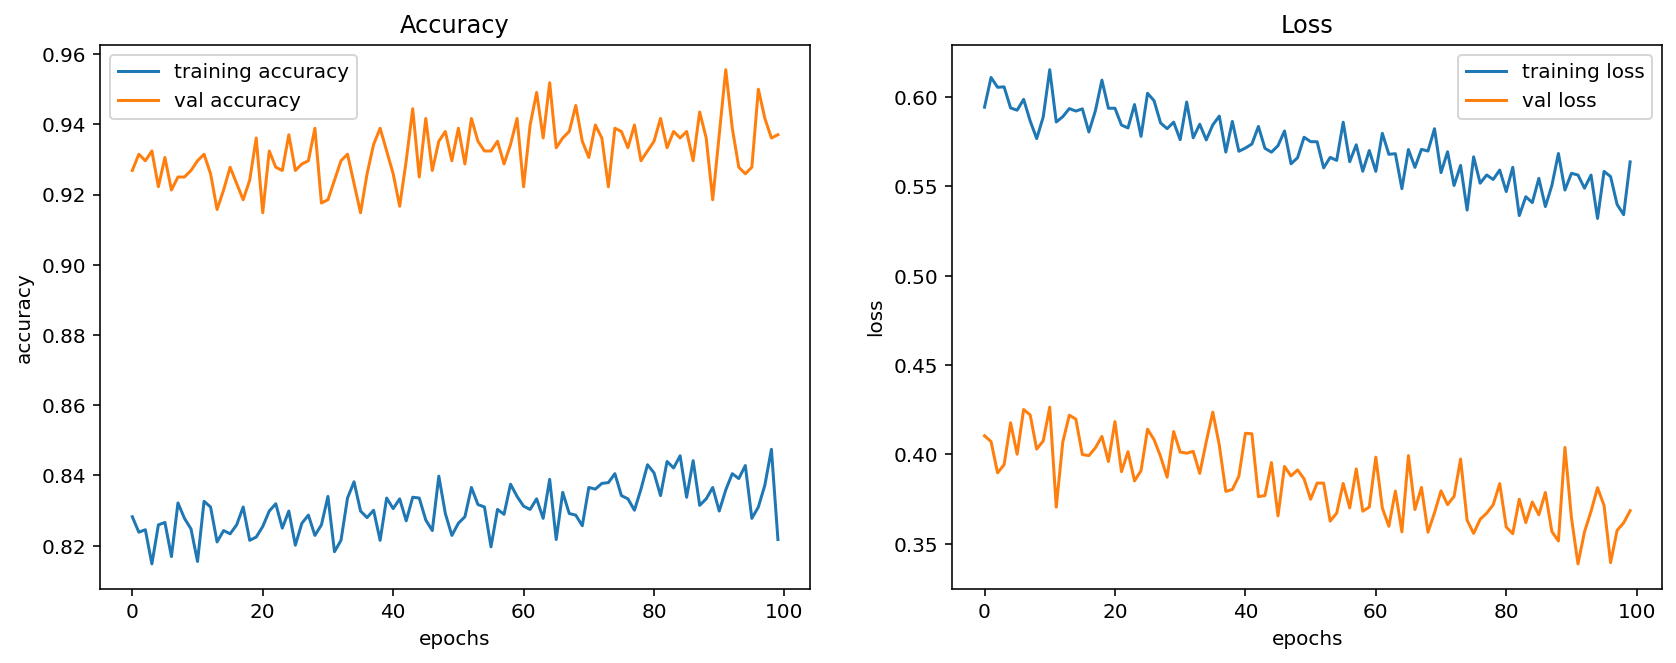

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
score = model.evaluate(validation_generator,verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

34/34 [==============================] - 173s 5s/step - loss: 0.3321 - accuracy: 0.9333
accuracy: 93.33%


In [ ]:
with open('/content/drive/MyDrive/wechat/model.json', 'w') as f:
    f.write(model.to_json())
model.save_weights('/content/drive/MyDrive/wechat/model.h5', overwrite=True)

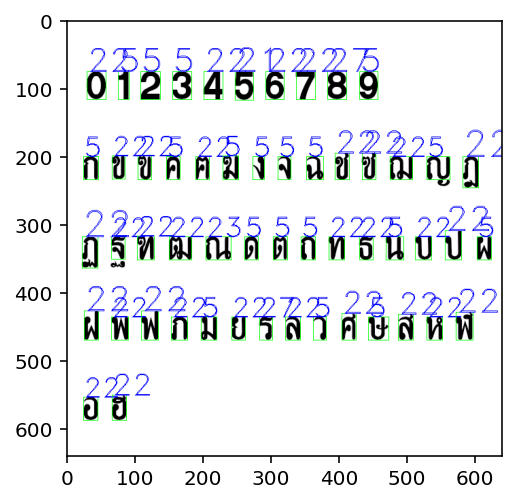

In [ ]:
def resize(rawimg):  # resize img to 28*28
    fx = 28.0 / rawimg.shape[0]
    fy = 28.0 / rawimg.shape[1]
    fx = fy = min(fx, fy)
    img = cv2.resize(rawimg, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
    outimg = np.ones((28, 28), dtype=np.uint8) * 255
    w = img.shape[1]
    h = img.shape[0]
    x = (28 - w) / 2
    y = (28 - h) / 2
    outimg[int(y):int(y+h), int(x):int(x+w)] = img
    return outimg


def convert(imgpath):   # read digits
    img = cv2.imread(imgpath)
    gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 25)
    ctrs, hier = cv2.findContours(bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]

    for rect in rects:
        x, y, w, h = rect
        roi = gray[y:y+h, x:x+w]
        hw = float(h) / w
        if (w < 200) & (h < 200) & (h > 10) & (w > 10) & (0 < hw) & (hw < 5) :
            res = resize(roi)
            res = np.resize(res, (1, 28, 28, 1))

            predictions = model.predict(res)
            predictions = np.argmax(predictions)
            # if predictions != 11:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
            cv2.putText(img, '{:.0f}'.format(predictions), (x, y), cv2.FONT_HERSHEY_DUPLEX, h/25.0, (255, 0, 0))
    return img

plt.imshow(convert('/content/1.png')[:,:,::-1])



```
# This is formatted as code
```

# LCND - 

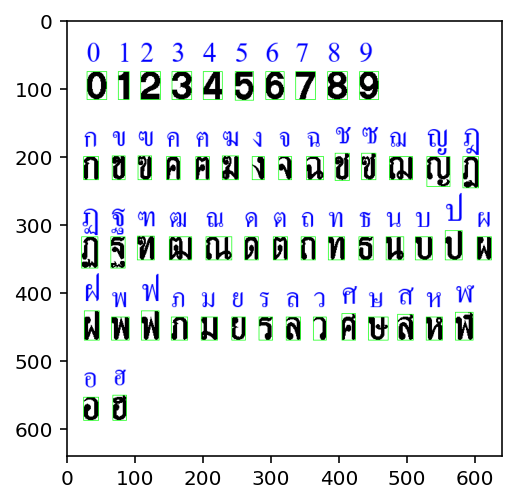

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

def resize(rawimg):  # resize img to 28*28
    fx = 28.0 / rawimg.shape[0]
    fy = 28.0 / rawimg.shape[1]
    fx = fy = min(fx, fy)
    img = cv2.resize(rawimg, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
    # 
    outimg = np.ones((28, 28), dtype=np.uint8) * 255

    w = img.shape[1]
    h = img.shape[0]
    x = (28 - w) / 2
    y = (28 - h) / 2
    outimg[int(y):int(y+h), int(x):int(x+w)] = img
    return outimg
def convert2(imgpath):   # read digits
    img = cv2.imread(imgpath)
    gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 25)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    threshed = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, rect_kernel)
    ctrs, hier = cv2.findContours(threshed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    characters = '0123456789กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮ'
    _char = ''
    for rect in rects:
        x, y, w, h = rect
        roi = gray[y:y+h, x:x+w]
        hw = float(h) / w
        if (w < 200) & (h < 200) & (h > 10) & (w > 10) & (0 < hw) & (hw < 5) :
            res = resize(roi)
            res = np.resize(res, (1, 28, 28, 1))

            predictions = model.predict(res)
            predictions = np.argmax(predictions)
            # if predictions != 10:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
            font = ImageFont.truetype('/content/angsana.ttc', int(h+20))
            img_pil = Image.fromarray(img)
            draw = ImageDraw.Draw(img_pil)
            draw.text((x,y-int(h+30)),characters[predictions], font=font,fill=(255,0,0))
            img = np.array(img_pil)
            # cv2.putText(img, '{:.0f}'.format(predictions), (x, y), cv2.FONT_HERSHEY_DUPLEX, h/40, (255, 0, 0))
    #         _char += characters[predictions]
    # print(int(h))
    return img

# imgpath = 'C:/Users/Suttinan Kanasit/Downloads/img002-00085.png'#'test_original_4.png_1d228bb5-d3f6-49c9-b68d-30c9ace0009d.png'
a='/content/2.png'
plt.imshow(convert2(a)[:,:,::-1])
# plt.imshow(convert2(a),cmap='gray')

# New Section